[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


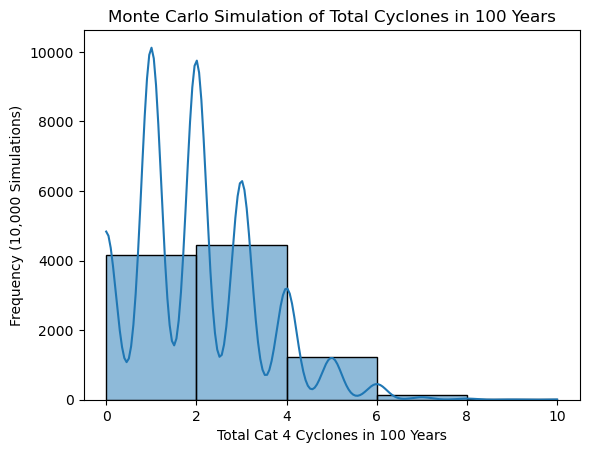

Expected number of cyclones in 100 years: 1.97
Probability of more than 3 cyclones in 100 years: 0.138


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

lambda_cat4 = 0.02  #occurance of an individual cyclone
years = 100  # Simulate for 100 years
num_simulations = 10000  # Number of Monte Carlo runs

a = np.random.poisson(lambda_cat4, years)
print(a)

total_cyclones = [np.sum(np.random.poisson(lambda_cat4, years)) for _ in range(num_simulations)]

# Plot distribution of total cyclones over 100 years
sns.histplot(total_cyclones, bins=5, kde=True)
plt.xlabel("Total Cat 4 Cyclones in 100 Years")
plt.ylabel("Frequency (10,000 Simulations)")
plt.title("Monte Carlo Simulation of Total Cyclones in 100 Years")
plt.show()

# Compute mean and probability of extreme scenarios
mean_cyclones = np.mean(total_cyclones)
prob_more_than_3 = np.sum(np.array(total_cyclones) > 3) / num_simulations

print(f"Expected number of cyclones in 100 years: {mean_cyclones:.2f}")
print(f"Probability of more than 3 cyclones in 100 years: {prob_more_than_3:.3f}")

# Expected number of cyclones in 100 years: 


In [2]:
from climada.hazard import TCTracks

#load the datasets
tc_hist_ni = TCTracks.from_hdf5('tc_hist_ni.hdf5')
list = tc_hist_ni.subset({'category': 3})


In [3]:
from climada.hazard import TCTracks, TropCyclone, Centroids

list.equal_timestep(
    0.5
)  # Interpolation to make the track smooth and to allow applying calc_perturbed_trajectories

# Add randomly generated tracks using the calc_perturbed_trajectories method (1 per historical track)
list.calc_perturbed_trajectories(nb_synth_tracks=1)
print("num tracks hist+syn:", list.size)

<string>:7: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
<string>:7: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
<string>:7: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
<string>:7: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
<string>:7: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
<string>:7: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
<string>:7: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
<string>:7: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
<string>:7: FutureWarning: 'T' is deprecated and

num tracks hist+syn: 24


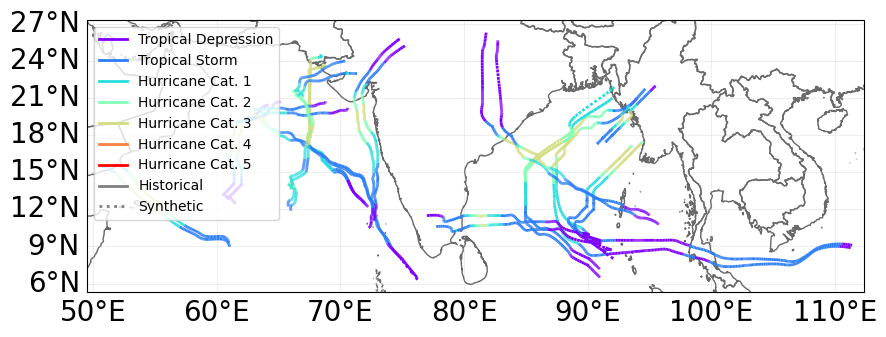

In [4]:
ax = list.plot()
ax.get_legend()._loc = 2

In [14]:
import pandas as pd
from climada.entity import Exposures

# Define exposrues here
file_name = 'power_assets.xlsx'
exposures = pd.read_excel(file_name)

exp  = Exposures(exposures, ref_year=2024)
print(exp)

description: None
ref_year: 2024
value_unit: USD
crs: EPSG:4326
data: (318 entries)
          value  production               Plant / Project name  \
0    1400750000       800.0          Adani Godda power station   
1    1050250000       600.0  Adani Raigarh Thermal Power Plant   
2     261625000       150.0     Aditya Aluminium power station   
3     261625000       150.0                Ajmer power station   
314    68850000        40.0         Wardha Works power station   
315  1400750000       800.0              Yadadri power station   
316  1400750000       800.0             Yermarus power station   
317   138950000        80.0          Zawar Mines power station   

                      geometry  
0    POINT (87.13546 24.81411)  
1    POINT (83.27409 21.74377)  
2    POINT (84.06059 21.74007)  
3    POINT (74.38500 26.07389)  
314  POINT (79.80000 20.46000)  
315  POINT (79.58118 16.70822)  
316  POINT (77.35612 16.29526)  
317  POINT (73.68000 24.58000)  


In [15]:
# Define the centroids from the exposures position
lat = exp.gdf["latitude"].values
lon = exp.gdf["longitude"].values
centrs = Centroids.from_lat_lon(lat, lon)

KeyError: 'latitude'

In [194]:
# Using the tracks, compute the windspeed at the location of the centroids
tc = TropCyclone.from_tracks(list, centroids=centrs)

In [193]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])

In [192]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [191]:
# Compute impact
from climada.engine import ImpactCalc

imp = ImpactCalc(exp, impf_set, tc).impact(
    save_mat=True
) # Save the impact in a mat file

print(imp)

In [190]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

Aggregated average annual impact: 2487371.0 $


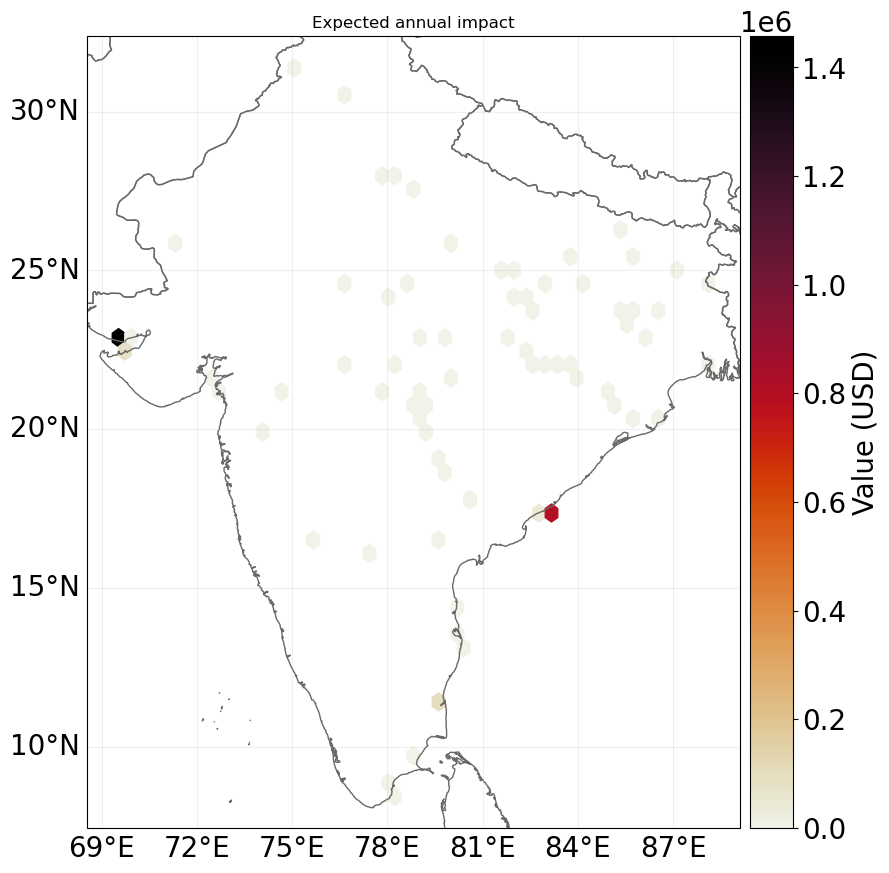

In [188]:
imp.plot_hexbin_eai_exposure(buffer=1, pop_name=False);